# Establishing a proxy for Na2O + K2O on subalkaline rocks

See the file about SiO2 proxy for more details. All QA/QC and data preparation is similar to that file. A SVM regression is chosen, as it gives the best results for SiO2.

In [1]:
%matplotlib inline

import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

from PIL import Image

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

## 1) Opening dataset and QA/QC

The dataset has been previously cleaned by Sarane. Only rock analysis are included, and samples are unaltered.

In [4]:
xl_file = pd.ExcelFile('sub_alcaline_dataset_GeoRock.xlsx')
dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
sheet_names = list(dfs.keys())
df = dfs[sheet_names[0]]

######### Removing columns with too many missing data
a = df.iloc[:, 15:91].count(axis=0)
a = len(df.index) - a
a[a!=0]
df.drop(a[a>50].index.values, axis=1, inplace=True)
######## Removing samples with missing data
df.dropna(subset=a[a<=50].index.values, inplace=True)

######## Drop all useless columns
df.drop(df.iloc[:, 35:].columns.values, axis=1, inplace=True)

######## Removing all lines with values <= 0
df = df[~(df.iloc[:, 15:] <= 0).any(axis=1)]

print ('Shape of the df dataset after transformation:' + str(df.shape))
df.head()

Shape of the df dataset after transformation:(2246, 35)


,Filename,Year,CITATION,SAMPLE NAME,num sample,LOCATION,LAND/SEA (SAMPLING),ROCK TYPE,ROCK NAME,ROCK TEXTURE,SAMPLE COMMENT,"LATITUDE (MIN,)","LONGITUDE (MIN,)","LATITUDE (MAX,)","LONGITUDE (MAX,)",SIO2(WT%),TIO2(WT%),AL2O3(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),BA(PPM),LA(PPM),CE(PPM),SM(PPM),EU(PPM),YB(PPM),TH(PPM)
0,C:\Documents and Settings\Administrator\Deskto...,2003.0,"[10333] KELLEY KATHERINE A,(2003) [GeoRem305]","samp, 185-1149D-11R-2-86-92",1.0,IZU-BONIN ARC / NADEZHDA BASIN / SITE 1149 / P...,SUBAQUATIC,VOLCANIC ROCK,BASALT,NaN,BRECCIA WITH CALCITE CEMENT,31.3132,143.4004,31.3132,143.4004,33.740000,1.170000,10.29000,37.910000,5.460000,0.319000,0.561000,2.210000,0.122000,152.00000,45.900000,79.100000,1.990000,34.500000,4.780000,7.260000,3.4700,1.200000,3.980000,0.117000
1,C:\Documents and Settings\Administrator\Deskto...,2003.0,"[10333] KELLEY KATHERINE A,(2003) [GeoRem305]","samp, 185-1149B-30R-1-61-66",2.0,IZU-BONIN ARC / NADEZHDA BASIN / SITE 1149 / P...,SUBAQUATIC,VOLCANIC ROCK,BASALT,NaN,BRECCIA WITH CALCITE CEMENT,31.3422,143.3510,31.3422,143.3510,37.310000,1.100000,9.86000,31.130000,7.310000,0.119000,1.190000,1.640000,0.113000,141.00000,32.200000,70.400000,1.730000,36.900000,2.250000,7.560000,2.3300,0.777000,2.610000,0.095000
2,C:\Documents and Settings\Administrator\Deskto...,2012.0,"[16063] ICHIYAMA Y, (2012)","samp, INO-R03",3.0,KURILE ARC / KURILE ARC / HOKKAIDO / KAMUIKOTA...,SUBAERIAL,VOLCANIC ROCK,PICRITE,NaN,NaN,NaN,NaN,43.5200,142.3000,40.020000,0.440000,5.61000,5.810000,29.040000,0.160000,0.030000,0.170000,0.050000,26.50000,7.700000,17.600000,0.500000,7.610000,0.560000,1.680000,0.7300,0.300000,0.810000,0.600000
3,C:\Documents and Settings\Administrator\Deskto...,2004.0,"[6859] GEORGE R, M, M, (2004)","samp, 96PSXEN",4.0,ALEUTIAN ARC / SECOND ALEUTIAN ARC / AKUTAN / ...,SUBAERIAL,VOLCANIC ROCK,"BASALT, THOLEIITIC",NaN,NaN,NaN,NaN,54.1700,-165.9200,42.190000,0.690000,26.09000,14.110000,5.640000,0.110000,0.070000,1.120000,0.030000,567.00000,2.100000,4.600000,0.090000,38.000000,0.690000,1.570000,0.3200,0.300000,0.200000,0.080000
4,C:\Documents and Settings\Administrator\Deskto...,2010.0,"[14927] NEILL I, (2010)","samp, IND/7,1",5.0,LESSER ANTILLES / LESSER ANTILLES / LA DESIRAD...,SUBAERIAL,VOLCANIC ROCK,"ANDESITE, BASALTIC",NaN,NaN,NaN,NaN,16.3000,-61.0000,42.871226,0.683324,15.20749,24.574663,3.905176,0.085926,0.032198,0.415829,0.099979,34.85988,15.564265,53.860745,1.243583,17.003967,5.699474,12.639669,2.5654,0.871789,1.563074,0.553056


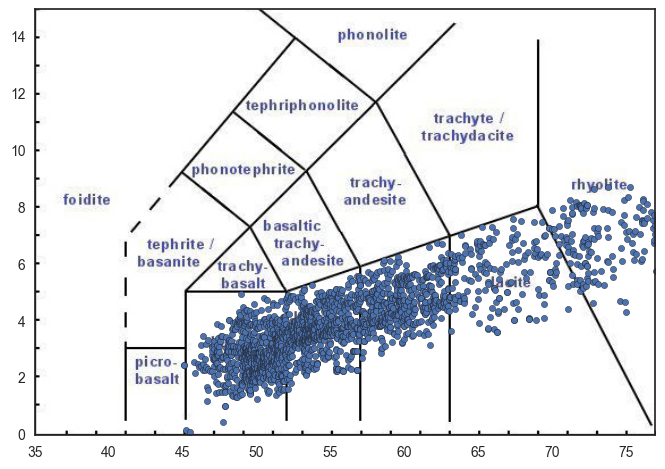

In [5]:
####### Removing alkaline samples
df = df.ix[(df['SIO2(WT%)']>45)]
df = df.ix[(df['NA2O(WT%)']+df['K2O(WT%)']<5) | (df['SIO2(WT%)']>52)]
a = (5-2)/(52-35)
b = 2-35*a
df = df.ix[(df['SIO2(WT%)']<52) | (df['NA2O(WT%)']+df['K2O(WT%)']<a*df['SIO2(WT%)']+b)]


###### TAS diagram
hor_ax = df['SIO2(WT%)']
vert_ax = df['K2O(WT%)'] + df['NA2O(WT%)']
im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\TAS diagram 77-15.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[35, 77, 0, 15], aspect='auto', cmap='gray')
ax.scatter(hor_ax, vert_ax)
ax.set(xlim=[35, 77], ylim=[0, 15])
plt.show()

## 2) Make SVM regression

In [6]:
def make_ALR(dataframe, element):
    temp_df = pd.DataFrame()
    for index, Series in dataframe.iterrows():
        Series = Series.apply(lambda x: x/Series[element])
        Series = np.log(Series)
        temp_df = temp_df.append(Series)
        temp_df.drop(element, axis=1, inplace=True)
    return temp_df

In [7]:
#### creating x and y
X = df.loc[:, ['TIO2(WT%)', 'AL2O3(WT%)', 'Y(PPM)', 'ZR(PPM)',
               'NB(PPM)', 'LA(PPM)', 'CE(PPM)', 'SM(PPM)', 'YB(PPM)', 'TH(PPM)']]
X = make_ALR(X, 'YB(PPM)')
y = df['NA2O(WT%)'] + df['K2O(WT%)']

#### creating test and train datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
C_range = 10.0 ** np.arange(-3, 3)
gamma_range= 10.0 ** np.arange(-3, 3)
param_grid = dict(svr__C=C_range, svr__gamma=gamma_range)
SVM = make_pipeline(StandardScaler(), SVR(cache_size=2000))
# scoring options: ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'log_loss', 'mean_squared_error', 'precision', 'r2', 'recall', 'roc_auc'] 
scores = ['r2']
print('Heat map:')
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print("Best parameters set found on development set:")
    grid = GridSearchCV(SVM, param_grid, cv=4, scoring='%s' % score, n_jobs=-1)
    #clf = grid.get_params()
    clf = grid.fit(X_train, y_train)
    print(clf.cv_results_['params'][clf.best_index_])
    print("Score: %0.03f" % clf.best_score_)
    print("")
    #for params, mean_score, scores in clf.grid_scores_:
         #print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
    # Do a graphic representation
    scores = [x[1] for x in clf.grid_scores_]
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))

Heat map:
# Tuning hyper-parameters for r2
Best parameters set found on development set:
{'svr__C': 10.0, 'svr__gamma': 0.10000000000000001}
Score: 0.868



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [9]:
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

Heat map:


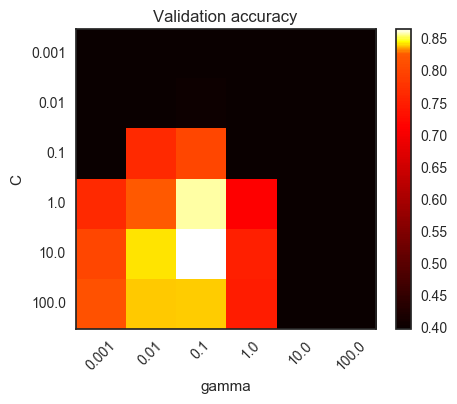

In [12]:
print('Heat map:')
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.3, right=0.8, bottom=0.3, top=0.8)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.4, midpoint=0.83))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

Score metrics on the test set:

In [13]:
####### Score on testing set
SVM = make_pipeline(StandardScaler(), SVR(gamma=0.1, C=100, cache_size=2000))
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
R2 = r2_score(y_test, y_pred)
Mean_error = mean_absolute_error(y_test, y_pred)
Median_error = median_absolute_error(y_test, y_pred)
Squared_error = mean_squared_error(y_test, y_pred)
print ('Scores obtained on the test dataset:\n R2: ' + str(R2) +
       '\n Mean absolute error:' + str(Mean_error) +
       '\n Median absolute error: ' + str(Median_error) + 
      '\n Mean squared error: ' + str(Squared_error))

Scores obtained on the test dataset:
 R2: 0.838893949402
 Mean absolute error:0.385013169761
 Median absolute error: 0.24040509165
 Mean squared error: 0.361369574689


Correlation of prediction vs analysis on the test set

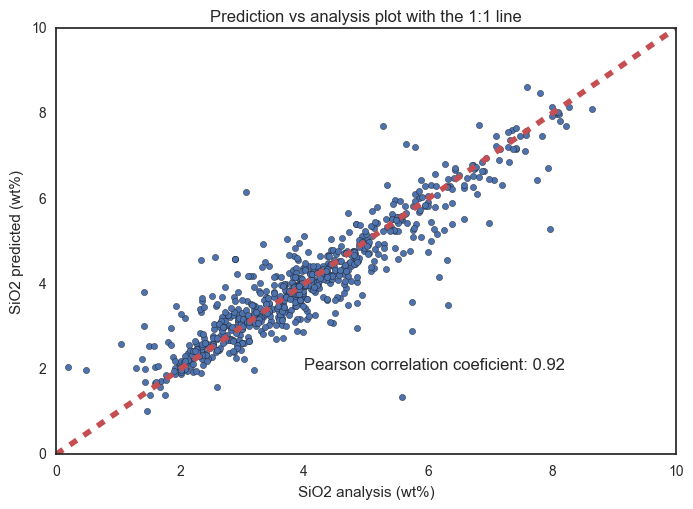

In [17]:
from scipy.stats.stats import pearsonr
corr = pearsonr(y_test, y_pred)

fig, ax = plt.subplots()
line = ax.plot([0, 10], [0, 10], 'r', linewidth=4, ls='--')
ax.scatter(y_test, y_pred)
ax.set(xlim=[0, 10], ylim=[0, 10])
ax.set(title='Prediction vs analysis plot with the 1:1 line')
ax.set_xlabel('SiO2 analysis (wt%)')
ax.set_ylabel('SiO2 predicted (wt%)')
ax.text(4, 2, 'Pearson correlation coeficient: %.2f' % (corr[0]))
plt.show()

Correlation of the prediction vs analysis on all data using cross_val_predict to avoid overfitting

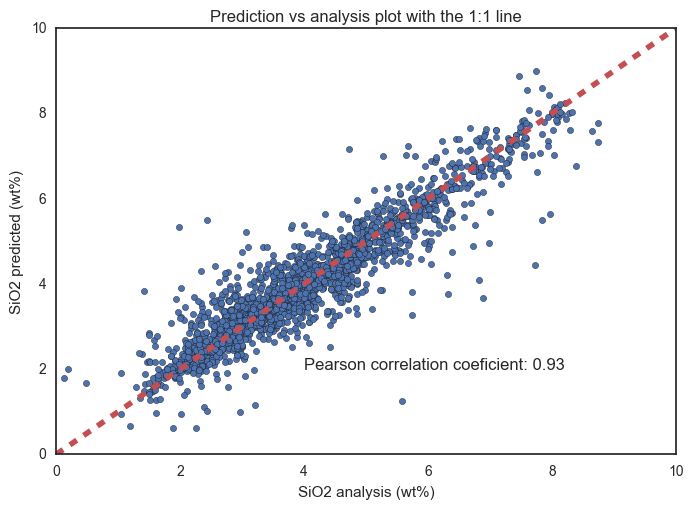

In [19]:
from sklearn.model_selection import cross_val_predict, KFold
cv = KFold(n_splits=10, shuffle=True)
y_pred = cross_val_predict(SVM, X, y, cv=cv, n_jobs=3)


from scipy.stats.stats import pearsonr
corr = pearsonr(y, y_pred)

fig, ax = plt.subplots()
line = ax.plot([0, 10], [0, 10], 'r', linewidth=4, ls='--')
ax.scatter(y, y_pred)
ax.set(xlim=[0, 10], ylim=[0, 10])
ax.set(title='Prediction vs analysis plot with the 1:1 line')
ax.set_xlabel('SiO2 analysis (wt%)')
ax.set_ylabel('SiO2 predicted (wt%)')
ax.text(4, 2, 'Pearson correlation coeficient: %.2f' % (corr[0]))
plt.show()